In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

In [2]:
# Get data
orbis = pd.read_csv('../data_collection/orbis_clean.csv')
orbis = orbis.drop('Unnamed: 0', axis=1)
gd = pd.read_csv('../reviews/all_df.csv')
gd = gd.drop('Unnamed: 0', axis=1)
industries = pd.read_csv('../data_collection/industries.csv')
industries = industries.drop('Unnamed: 0', axis=1)

<ipython-input-2-223cfa39998f>:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  gd = pd.read_csv('../reviews/all_df.csv')


In [3]:
industries = industries.rename(columns={"Nom de l'entreprise Latin alphabet": 'name',
                                       'Numéro Orbis': 'orbis_nbr',
                                       'BvD sectors': 'bvd_sector',
                                       'Code SIC (US) Code(s) Primaire(s)': 'primary_sic',
                                       'US SIC Principal, description textuelle': 'primary_sic_txt',
                                       'Code SIC (US) Code(s) Secondaire(s)': 'secundary_sic',
                                       'US SIC secondaire, description textuelle': 'secundary_sic_txt'})

In [4]:
# Exclude companies with less than 30 reviews
count_companies = gd.groupby('orbis_name')['review_id'].count()
gd = gd[gd['orbis_name'].isin(count_companies[count_companies >= 30].index)]

In [5]:
# Complete dataset
# Merge financial and reviews and classification
orbis_gd = pd.merge(orbis, gd, left_on='name', right_on='orbis_name')
orbis_gd = pd.merge(orbis_gd, industries, on='orbis_nbr')

In [6]:
# Developement dataset!
#orbis_gd = orbis_gd.sample(frac =.10)

In [7]:
orbis_gd.shape

(567044, 251)

In [8]:
# Convert certain columns to numeric
def numerize_friend(string):
    if string == '"NEGATIVE"':
        return -1
    elif string == '"POSITIVE"':
        return 1
    else:
        return np.nan
    
def numerize_ceo(string):
    if string == '"DISAPPROVE"':
        return -1
    elif string == '"APPROVE"':
        return 1
    else:
        return np.nan
    
def numerize_outlook(string):
    if string == '"NEUTRAL"':
        return 0
    elif string == '"POSITIVE"':
        return 1
    elif string == '"NEGATIVE"':
        return -1
    else:
        return np.nan
    
orbis_gd['rating_recommend_friend'] = orbis_gd['rating_recommend_friend'].apply(numerize_friend)
orbis_gd['rating_ceo'] = orbis_gd['rating_ceo'].apply(numerize_ceo)
orbis_gd['rating_businessoutlook'] = orbis_gd['rating_businessoutlook'].apply(numerize_outlook)

In [9]:
# Remove industries with less than 1000 reviews
sector_counts = orbis_gd.groupby('bvd_sector')['review_id'].count()

to_remove = sector_counts[sector_counts < 1000]
to_remove.index
orbis_gd = orbis_gd[~orbis_gd['bvd_sector'].isin(to_remove.index)]

### Basic exploration

In [10]:
orbis_gd.shape

(566343, 251)

In [11]:
# Convert the Timestamp column to datetime format
orbis_gd['review_datetime'] = pd.to_datetime(orbis_gd['review_datetime'])

# Enough rating from mid 2016, remove before
orbis_gd = orbis_gd[orbis_gd['review_datetime'] > datetime(2017, 6, 1)]

# Diversity and inclusion starts only in mid 2020
orbis_gd.loc[orbis_gd['review_datetime'] < datetime(2021, 1, 1), 'rating_diversity_inclusion'] = np.nan

In [12]:
# Parsing went wrong for 237 - 6 = 231 reviews
print(len(orbis_gd['review_overall'].unique()))

# convert non-numeric values to NaN
orbis_gd['review_overall'] = pd.to_numeric(orbis_gd['review_overall'], errors='coerce')

# replace NaN values with a specific value, if desired
orbis_gd['review_overall'].fillna(value=np.nan, inplace=True)

print(len(orbis_gd['review_overall'].unique()))


237
6


### Distribution of industries

In [13]:
# get sample data for chatgpt
#orbis_gd[:2].to_dict()

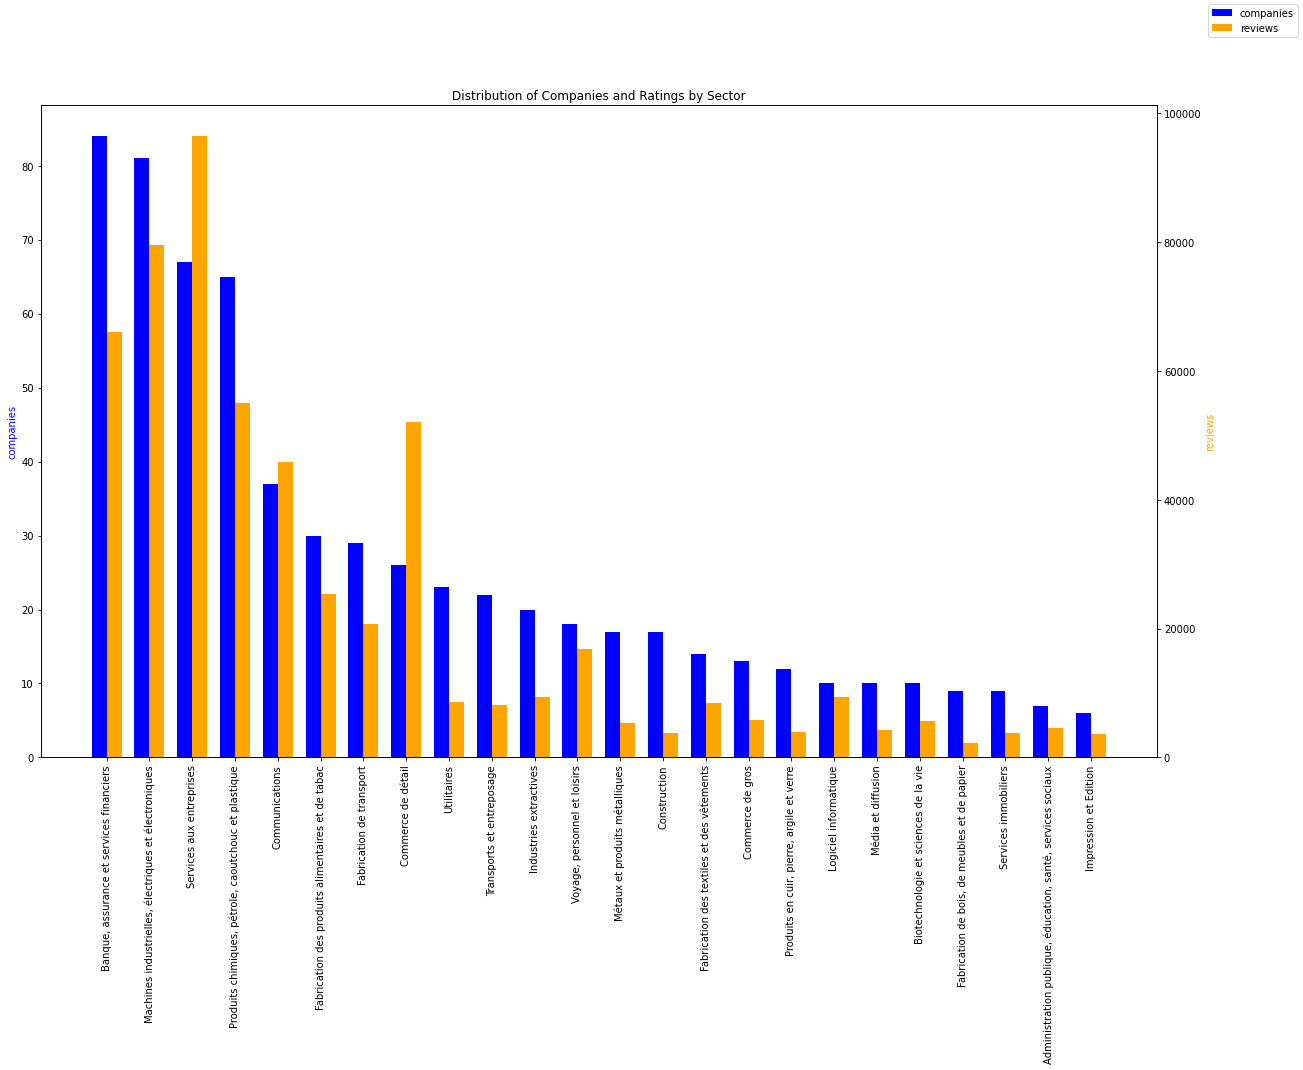

In [14]:
companies_per_sector = orbis_gd.groupby('bvd_sector')['name_x'].nunique().sort_values(ascending=False)
reviews_per_sector = orbis_gd.groupby('bvd_sector')['orbis_nbr'].count().reindex(companies_per_sector.index)

fig, ax1 = plt.subplots(figsize=(20, 12))

# set the width of each bar
width = 0.35

# create a range of x-values for the first bar chart
x1 = np.arange(len(companies_per_sector.index))

# plot the first bar chart
ax1.bar(x1, companies_per_sector.values, color='blue', width=width, label='companies')

# set the x-tick labels for the first bar chart
ax1.set_xticks(x1)
ax1.set_xticklabels(companies_per_sector.index, rotation=90)

# set the y-axis label for the first bar chart
ax1.set_ylabel('companies', color='blue')

# create a range of x-values for the second bar chart, shifted by the width of each bar
x2 = x1 + width

# plot the second bar chart
ax2 = ax1.twinx()
ax2.bar(x2, reviews_per_sector.values, color='orange', width=width, label='reviews')

# set the x-tick labels for the second bar chart
ax2.set_xticks(x1 + width/2)
ax2.set_xticklabels(reviews_per_sector.index, rotation=90)

# set the y-axis label for the second bar chart
ax2.set_ylabel('reviews', color='orange')

# add legend
fig.legend()
#ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')

plt.title('Distribution of Companies and Ratings by Sector')

plt.show()


### Ratings over time global

In [15]:
monthly_ratings = orbis_gd.groupby(pd.Grouper(key='review_datetime', freq='M'))['rating_worklifebalance',
                                                                        'rating_culture_values',
                                                                        'rating_diversity_inclusion',
                                                                        'rating_senior_leadership',
                                                                        'rating_career_opport',
                                                                        'rating_compensation_benefits'].mean()
# Enough rating from mid 2016, remove before
monthly_ratings = monthly_ratings[monthly_ratings.index > datetime(2017, 6, 1)]

# Diversity and inclusion starts only in mid 2020
monthly_ratings.loc[monthly_ratings.index < datetime(2021, 1, 1), 'rating_diversity_inclusion'] = np.nan

<ipython-input-15-4ca51bb4510e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  monthly_ratings = orbis_gd.groupby(pd.Grouper(key='review_datetime', freq='M'))['rating_worklifebalance',


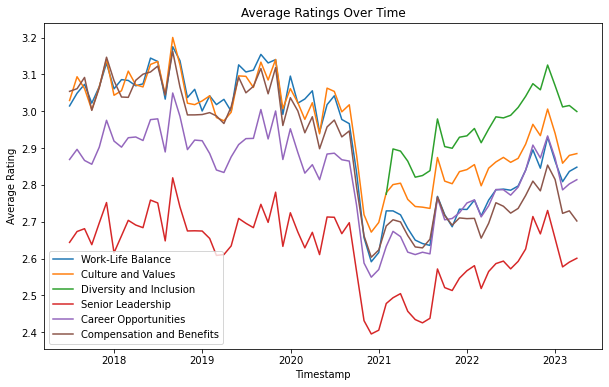

In [16]:
# Plot the average ratings over time using a line plot

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(monthly_ratings.index, monthly_ratings['rating_worklifebalance'], label='Work-Life Balance')
ax.plot(monthly_ratings.index, monthly_ratings['rating_culture_values'], label='Culture and Values')
ax.plot(monthly_ratings.index, monthly_ratings['rating_diversity_inclusion'], label='Diversity and Inclusion')
ax.plot(monthly_ratings.index, monthly_ratings['rating_senior_leadership'], label='Senior Leadership')
ax.plot(monthly_ratings.index, monthly_ratings['rating_career_opport'], label='Career Opportunities')
ax.plot(monthly_ratings.index, monthly_ratings['rating_compensation_benefits'], label='Compensation and Benefits')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Average Rating')
ax.set_title('Average Ratings Over Time')
ax.legend()
plt.show()

## Rating by industry over time

In [17]:
ratings = ['rating_worklifebalance',
        'rating_culture_values',
        'rating_diversity_inclusion',
        'rating_senior_leadership',
        'rating_career_opport',
        'rating_compensation_benefits']

In [18]:
sectors = orbis_gd['bvd_sector'].unique()

In [19]:
monthly_average_industry = {}
for sector in sectors:
    sector_data = orbis_gd[orbis_gd['bvd_sector'] == sector]
    monthly_average_industry[sector] = sector_data.groupby(pd.Grouper(key='review_datetime', freq='M'))[ratings].mean()

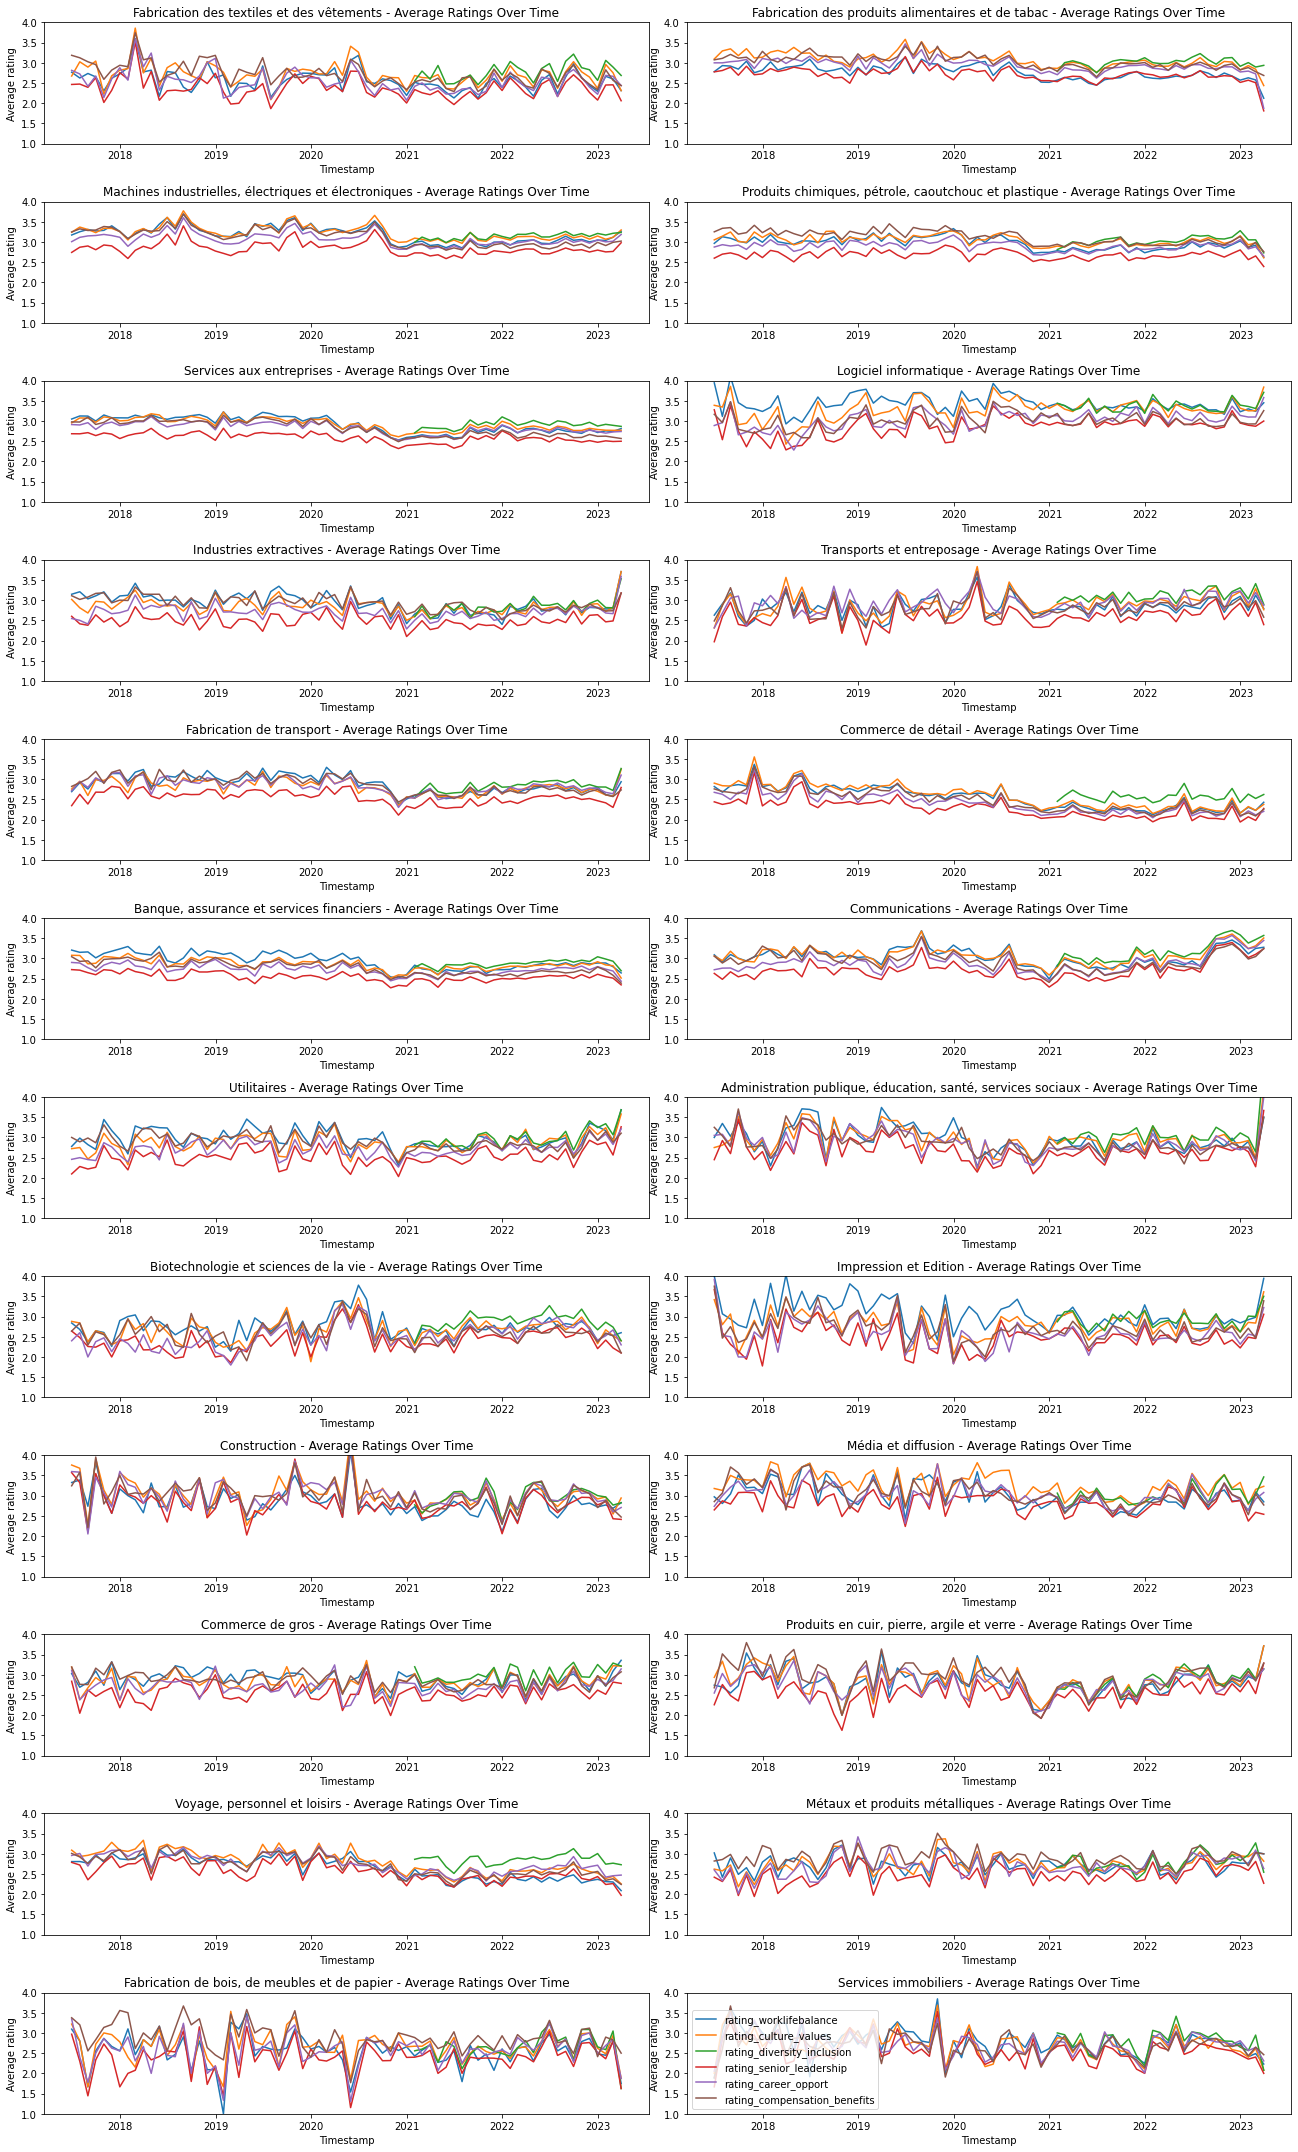

In [20]:
fig, axs = plt.subplots(nrows=12, ncols=2, figsize=(18, 30))

for rating in ratings:
    for i, sector in enumerate(sectors):
        row = i // 2
        col = i % 2
        ax = axs[row, col]
        
        ax.plot(monthly_average_industry[sector].index, monthly_average_industry[sector][rating], label=rating)
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Average rating')
        ax.set_title(f'{sector} - Average Ratings Over Time')
        ax.set_ylim(1, 4)
ax.legend()
plt.tight_layout()
plt.show()


A lot of collinearity.

In [21]:
orbis_gd['bvd_sector'].value_counts()

Services aux entreprises                                       96438
Machines industrielles, électriques et électroniques           79594
Banque, assurance et services financiers                       66008
Produits chimiques, pétrole, caoutchouc et plastique           54989
Commerce de détail                                             52063
Communications                                                 45895
Fabrication des produits alimentaires et de tabac              25432
Fabrication de transport                                       20740
Voyage, personnel et loisirs                                   16827
Logiciel informatique                                           9414
Industries extractives                                          9304
Utilitaires                                                     8671
Fabrication des textiles et des vêtements                       8453
Transports et entreposage                                       8203
Commerce de gros                  

Does not seem to be due by insufficent sample size.

Let's get this information into a table:

## For each industry, each rating take the 90 and 10th percentile and get the difference to see for each period each indsutry how this went

In [22]:
def get_period(date):
    if datetime(2021, 8, 1) >= date >= datetime(2020, 3, 18):
        return 2
    elif datetime(2021, 8, 1) < date:
        return 3
    else:
        return 1

In [23]:
orbis_gd['period'] = orbis_gd['review_datetime'].apply(get_period)

In [24]:
# Get average rating by company by period
review_period = orbis_gd.groupby(['orbis_name', 'bvd_sector', 'period'])['review_overall'].agg(['mean', 'count'])

In [25]:
review_period

mean  \
orbis_name                bvd_sector                               period             
3I GROUP PLC              Banque, assurance et services financiers 1       3.937500   
                                                                   2       4.000000   
                                                                   3       4.375000   
A P MOLLER-MAERSK A/S     Transports et entreposage                2       4.048643   
                                                                   3       4.158699   
...                                                                             ...   
ZALANDO SE                Commerce de détail                       2       3.929360   
                                                                   3       3.891348   
ZURICH INSURANCE GROUP AG Banque, assurance et services financiers 1       2.952381   
                                                                   2       3.562500   
                                                                   3       3.172414   

                                                                           count  
orbis_name                bvd_sector                               period         
3I GROUP PLC              Banque, assurance et services financiers 1          16  
                                                                   2           7  
                                                                   3          16  
A P MOLLER-MAERSK A/S     Transports et entreposage                2         884  
                                                                   3        1506  
...                                                                          ...  
ZALANDO SE                Commerce de détail                       2         453  
                                                                   3         497  
ZURICH INSURANCE GROUP AG Banque, assurance et services financiers 1          21  
                                                                   2          16  
                                                                   3          29  

[1833 rows x 2 columns]

In [26]:
# Remove if too little reviews in a given period
review_period = review_period[review_period['count'] > 20]

In [27]:
# Companies by industry
company_counts = review_period.groupby('bvd_sector').size().rename('Company Count')

In [28]:
# Build df with 90-10th and 75-25th company rating percentile within each industry for each period
variability_desc = review_period.pivot_table(values='mean', 
                                             index='bvd_sector', 
                                             columns='period', 
                                             aggfunc=lambda x: ((np.percentile(x, 90) - np.percentile(x, 10)).round(2), 
                                                                (np.percentile(x, 75) - np.percentile(x, 25)).round(2)))
variability_desc = variability_desc.rename(columns={1: 'Pre-lockdown (90th-10th, 75th-25th)', 2: 'During lockdown', 3: 'Post-lockdown'})

In [29]:
variability = variability_desc.merge(company_counts, left_index=True, right_index=True)
variability.sort_values('Company Count', ascending=False)

,"Pre-lockdown (90th-10th, 75th-25th)",During lockdown,Post-lockdown,Company Count
bvd_sector,,,,
"Machines industrielles, électriques et électroniques","(1.03, 0.69)","(0.81, 0.43)","(0.78, 0.41)",208
"Banque, assurance et services financiers","(0.85, 0.46)","(0.55, 0.3)","(0.69, 0.33)",190
Services aux entreprises,"(0.94, 0.5)","(0.85, 0.32)","(0.79, 0.35)",168
"Produits chimiques, pétrole, caoutchouc et plastique","(0.76, 0.4)","(0.53, 0.28)","(0.74, 0.42)",157
Communications,"(0.94, 0.48)","(0.8, 0.49)","(1.0, 0.51)",85
Fabrication de transport,"(0.67, 0.42)","(0.85, 0.39)","(0.68, 0.39)",75
Fabrication des produits alimentaires et de tabac,"(0.9, 0.44)","(0.63, 0.41)","(0.82, 0.45)",71
Commerce de détail,"(0.91, 0.32)","(1.02, 0.36)","(0.99, 0.4)",64
Transports et entreposage,"(1.08, 0.69)","(0.76, 0.43)","(0.98, 0.46)",53


Table showing number of firms, number of reviews, mean, median, max and min. amount of reviews and decide at how much to exclude

In [30]:
descriptable = orbis_gd.groupby('bvd_sector').agg(
                        review_count = ('review_id', 'count'),
                        company_count = ('name_x', 'nunique'),
                        avg_overall = ('review_overall', 'mean'),
                        avg_worklife_balance = ('rating_worklifebalance', 'mean'),
                        avg_culture_values = ('rating_culture_values', 'mean'),
                        avg_diversity_inclusion = ('rating_diversity_inclusion', 'mean'),
                        avg_senior_leadership = ('rating_senior_leadership', 'mean'),
                        avg_career_opportunities = ('rating_career_opport', 'mean'),
                        avg_compensation_benefits = ('rating_compensation_benefits', 'mean'),
                        avg_friend_recommendation = ('rating_recommend_friend', 'mean'),
                        avg_ceo = ('rating_ceo', 'mean'),
                        avg_businessoutlook = ('rating_businessoutlook', 'mean')).sort_values(by=['review_count'], ascending=False)
descriptable

,review_count,company_count,avg_overall,avg_worklife_balance,avg_culture_values,avg_diversity_inclusion,avg_senior_leadership,avg_career_opportunities,avg_compensation_benefits,avg_friend_recommendation,avg_ceo,avg_businessoutlook
bvd_sector,,,,,,,,,,,,
Services aux entreprises,96438,67,3.741399,2.822964,2.861901,2.904431,2.553112,2.777743,2.738599,0.441958,0.675339,0.434078
"Machines industrielles, électriques et électroniques",79594,81,3.932332,3.119142,3.188431,3.129332,2.816029,3.037993,3.056135,0.573805,0.766653,0.557317
"Banque, assurance et services financiers",66008,84,3.755371,2.852245,2.812705,2.872343,2.514407,2.695794,2.696325,0.444830,0.646261,0.374520
"Produits chimiques, pétrole, caoutchouc et plastique",54989,65,3.863500,2.918729,3.010857,3.024010,2.663278,2.873393,3.055775,0.518826,0.712124,0.496997
Commerce de détail,52063,26,3.614390,2.403454,2.446594,2.577690,2.171811,2.294067,2.341125,0.336648,0.440378,0.268272
Communications,45895,37,3.900708,3.061118,3.128816,3.257775,2.824905,2.994727,2.944133,0.536952,0.730490,0.499834
Fabrication des produits alimentaires et de tabac,25432,30,3.871186,2.716106,3.029097,3.008807,2.688070,2.906692,2.979632,0.533537,0.751142,0.514351
Fabrication de transport,20740,29,3.786596,2.780665,2.746336,2.818573,2.489634,2.765911,2.766924,0.465813,0.682375,0.396360
"Voyage, personnel et loisirs",16827,18,3.557259,2.533369,2.691329,2.855077,2.484816,2.674689,2.610091,0.284831,0.503115,0.282955


Identify bigrams in different industries in pre, during and post pandemic (use spacy) word cloud
Part of speech check dm notebook
Correlations between ratings and financials
4 part diagram with count high ratings good financialsm and other combinations as a teaser




## Test

In [1]:
import pandas as pd
#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#from nltk.corpus import stopwords
#from nltk.stem import PorterStemmer
#from nltk.tokenize import word_tokenize
#from collections import Counter
#from sklearn.linear_model import LassoCV
import pickle

In [2]:
"""
orbis_gd_ = orbis_gd.dropna(subset=['review_overall'])

# Convert the 'pros', 'cons', and 'advice' columns to strings
orbis_gd_['pros'] = orbis_gd_['pros'].astype(str)
orbis_gd_['cons'] = orbis_gd_['cons'].astype(str)
orbis_gd_['advice'] = orbis_gd_['advice'].astype(str)

# Remove special characters and convert to lowercase
orbis_gd_['pros'] = orbis_gd_['pros'].str.replace('[^\w\s]', '').str.lower()
orbis_gd_['cons'] = orbis_gd_['cons'].str.replace('[^\w\s]', '').str.lower()
orbis_gd_['advice'] = orbis_gd_['advice'].str.replace('[^\w\s]', '').str.lower()

# Tokenize the text
orbis_gd_['pros'] = orbis_gd_['pros'].apply(word_tokenize)
orbis_gd_['cons'] = orbis_gd_['cons'].apply(word_tokenize)
orbis_gd_['advice'] = orbis_gd_['advice'].apply(word_tokenize)

# Remove stopwords and perform stemming
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

orbis_gd_['pros'] = orbis_gd_['pros'].apply(lambda x: [stemmer.stem(word) for word in x if word not in stop_words])
orbis_gd_['cons'] = orbis_gd_['cons'].apply(lambda x: [stemmer.stem(word) for word in x if word not in stop_words])
orbis_gd_['advice'] = orbis_gd_['advice'].apply(lambda x: [stemmer.stem(word) for word in x if word not in stop_words])

# Step 2: Feature extraction
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=1500)  # Adjust ngram_range as needed
pros_features = vectorizer.fit_transform(orbis_gd_['pros'].apply(' '.join))
cons_features = vectorizer.fit_transform(orbis_gd_['cons'].apply(' '.join))
# Multiply cons_features by -1 to make it a negative parameter
cons_features *= -1
advice_features = vectorizer.fit_transform(orbis_gd_['advice'].apply(' '.join))

# Concatenate pros_features, cons_features, and advice_features
X = pd.concat([pd.DataFrame(pros_features.toarray()), pd.DataFrame(cons_features.toarray()), pd.DataFrame(advice_features.toarray())], axis=1)
y = orbis_gd_['review_overall']

# Save X and y to a pickle file
with open('xy_lasso.pickle', 'wb') as file:
    pickle.dump((X, y), file)
"""

"\norbis_gd_ = orbis_gd.dropna(subset=['review_overall'])\n\n# Convert the 'pros', 'cons', and 'advice' columns to strings\norbis_gd_['pros'] = orbis_gd_['pros'].astype(str)\norbis_gd_['cons'] = orbis_gd_['cons'].astype(str)\norbis_gd_['advice'] = orbis_gd_['advice'].astype(str)\n\n# Remove special characters and convert to lowercase\norbis_gd_['pros'] = orbis_gd_['pros'].str.replace('[^\\w\\s]', '').str.lower()\norbis_gd_['cons'] = orbis_gd_['cons'].str.replace('[^\\w\\s]', '').str.lower()\norbis_gd_['advice'] = orbis_gd_['advice'].str.replace('[^\\w\\s]', '').str.lower()\n\n# Tokenize the text\norbis_gd_['pros'] = orbis_gd_['pros'].apply(word_tokenize)\norbis_gd_['cons'] = orbis_gd_['cons'].apply(word_tokenize)\norbis_gd_['advice'] = orbis_gd_['advice'].apply(word_tokenize)\n\n# Remove stopwords and perform stemming\nstop_words = set(stopwords.words('english'))\nstemmer = PorterStemmer()\n\norbis_gd_['pros'] = orbis_gd_['pros'].apply(lambda x: [stemmer.stem(word) for word in x if wor

In [3]:
# Load X and y from the pickle file
with open('xy_lasso.pickle', 'rb') as file:
    X, y = pickle.load(file)

In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Find best alpha

alphas = np.logspace(-6, 6, 13)  # Generate a list of alpha values on a logarithmic scale
lassocv_reg = LassoCV(alphas=alphas, verbose=1)  # Create an instance of LassoCV with the alpha values
lassocv_reg.fit(X_train, y_train)  # Fit the LassoCV model using training data

alpha = lassocv_reg.alpha_  # Retrieve the best alpha value selected by cross-validation
print("Best alpha:", alpha)

In [ ]:
# Fit a Lasso regression model
lasso = Lasso(alpha=0.01)  # Adjust alpha value as needed
lasso.fit(X_train, y_train)

In [ ]:
# Evaluate the model on the testing data
score = lasso.score(X_test, y_test)
print("Model Score:", score)

In [ ]:
# Step 4: Identify impactful grams and bigrams
feature_names = vectorizer.get_feature_names()
coefficients = pd.Series(lasso.coef_, index=feature_names)

In [ ]:
# Get the most impactful grams and bigrams
positive_features = coefficients[coefficients > 0].nlargest

## Text

In [ ]:
text_cols = ['pros', 'cons', 'advice']

In [ ]:
orbis_gd[['pros', 'cons', 'advice', 'review_overall']]

In [ ]:
from nltk import ngrams
from collections import Counter
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LassoCV


translator = str.maketrans('','',punctuation) 
stoplist = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

In [ ]:
def normalize_text(doc):
    "Input doc and return clean text"
    if isinstance(doc, float):
        return ""
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

In [ ]:
# Normalize text
for col in text_cols:
    orbis_gd[f'{col}_normalized'] = orbis_gd[col].apply(normalize_text)

In [ ]:
dfs_period = {}
# Normalize text
for period in range(3):
    dfs_period[f'df_{period}'] = orbis_gd[orbis_gd['period'] == period]

In [ ]:
# Step 2: Create separate feature matrices for pros and cons

distinct_count_pros = orbis_gd['pros_normalized'].explode().value_counts()
distinct_count_cons = orbis_gd['cons_normalized'].explode().value_counts()
grams_pros = distinct_count_pros[:2000].index
grams_cons = distinct_count_cons[:2000].index
orbis_gd['use_pro_grams'] = orbis_gd['pros_normalized'][:2000].apply(lambda x: [gram for gram in x if gram in grams_pros])
orbis_gd['use_cons_grams'] = orbis_gd['cons_normalized'][:2000].apply(lambda x: [gram for gram in x if gram in grams_cons])

df_lasso = orbis_gd.dropna(subset=['use_pro_grams', 'use_cons_grams', 'review_overall'], inplace=False)

# Create bag of words model
ngram_vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
# Extract and vectorize pros bigrams
X_pros = ngram_vectorizer.fit_transform(df_lasso['use_pro_grams'])
# Extract and vectorize cons bigrams
X_cons = ngram_vectorizer.fit_transform(df_lasso['use_cons_grams'])
  

# Step 3: Assign appropriate signs to the cons bigram features
X_cons *= -1

# Step 4: Concatenate the pros and cons feature matrices
X = np.concatenate((X_pros.toarray(), X_cons.toarray()), axis=1)

# Step 5: Prepare the target variable
y = df_lasso['review_overall']

# Step 6: Fit the Lasso regression model
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Find best alpha

alphas = np.logspace(-6, 6, 13)  # Generate a list of alpha values on a logarithmic scale
lassocv_reg = LassoCV(alphas=alphas, verbose=1)  # Create an instance of LassoCV with the alpha values
lassocv_reg.fit(X_train, y_train)  # Fit the LassoCV model using training data

alpha = lassocv_reg.alpha_  # Retrieve the best alpha value selected by cross-validation
print("Best alpha:", alpha)

In [ ]:
# Once Lasso fixedm evaluate it for the three periods 
# Initialize Lasso regression model with best regularization parameter alpha
lasso_model = Lasso(alpha=alpha)  # Need to perform grid_searchm the higher the stronger the simplification of the model
lasso_model.fit(X_train, y_train)

# Predict on train and test data
y_train_pred = lasso_model.predict(X_train)
y_test_pred = lasso_model.predict(X_test)

# Calculate MSE for train and test predictions
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Train MSE:", mse_train)
print("Test MSE:", mse_test)

In [ ]:
features = grams_pros + grams_cons

In [ ]:
print('The coefficients of the features from the Ridge model:')
features_coeff = dict(zip(features, [round(x, 2) for x in lasso_model.coef_]))
impactful_grams = {key: value for key, value in features_coeff.items() if value != 0}
print(impactful_grams)

## In development

In [ ]:
# Wordclouds for all three periods

# Convert the lists to strings, removing any float values
pros_string = ' '.join(str(word) for word in orbis_gd['pros_normalized'].explode().values if not isinstance(word, float))
cons_string = ' '.join(str(word) for word in orbis_gd['cons_normalized'].explode().values if not isinstance(word, float))


# Generate word cloud for pros_normalized
pros_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(pros_string)

# Generate word cloud for cons_normalized
cons_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cons_string)

# Plot word cloud for pros_normalized
plt.figure(figsize=(10, 5))
plt.imshow(pros_wordcloud, interpolation='bilinear')
plt.title('Pros Word Cloud')
plt.axis('off')
plt.show()

# Plot word cloud for cons_normalized
plt.figure(figsize=(10, 5))
plt.imshow(cons_wordcloud, interpolation='bilinear')
plt.title('Cons Word Cloud')
plt.axis('off')
plt.show()

In [ ]:
"""
# TAKES TOO LONG
# Mutual Information

# Tokenize grams and bigrams
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(orbis_gd['pros_normalized'][:10000])

# Handle missing values in the target variable
y = orbis_gd['review_overall'][:10000]
y = y.fillna(0)  # Replace NaN values with 0 or use another suitable strategy

# Calculate mutual information scores
mi_scores = mutual_info_classif(X, y)

# Sort the scores and select top N features
k = 100 # Number of top features to select
top_features_indices = mi_scores.argsort()[-k:][::-1]
top_features = [vectorizer.get_feature_names()[i] for i in top_features_indices]

print(top_features)
"""

In [ ]:
norm_text_cols = ['pros_normalized', 'cons_normalized', 'advice_normalized']

In [ ]:
def n_grams(row):
    grams = []
    for n in range(1,3):
        grams += list(ngrams(row, n))
    return grams

In [ ]:
# Get grams and bigrams
for col in norm_text_cols:
    orbis_gd[f'{col}_grams'] = orbis_gd[col].apply(n_grams)

In [ ]:
Get the most important words? Mutual info maybe
Plot them on a word cloud


In [ ]:
orbis_gd['pros_normalized_grams_comma'] = orbis_gd['pros_normalized_grams'].apply(
    lambda grams: ', '.join([gram[0] if len(gram) == 1 else ' '.join(gram) for gram in grams])
)

In [ ]:
comma_sep[0]


In [ ]:
orbis_gd['pros_normalized']

In [ ]:
# Tokenize grams and bigrams
vectorizer = CountVectorizer(ngram_range=(1, 2))
Y = vectorizer.fit_transform(orbis_gd['pros_normalized'])

In [ ]:
X

In [ ]:
# Have to drop missing data for lasso
df_text = orbis_gd.dropna(subset=['pros_normalized', 'cons_normalized', 'review_overall'], inplace=False)

In [ ]:
orbis_gd[['pros_normalized', 'cons_normalized', 'review_overall']]

A lot of words are uselessm let's try to plot the words with the most meaning (nutual info)

In [ ]:
df

In [ ]:
df['pros_normalized'].explode()

In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression

# Create a DataFrame
data = {
    'pros_normalized': [
        ['four', 'day', 'week', 'lunch', 'allow'],
        ['good', 'packag', 'nice', 'work', 'environ'],
        ['it', 'good', 'place', 'learn', 'present', 'it', 'make', 'di'],
        ['good', 'employe', 'benefit', 'compani', 'train', 'year'],
        ['great', 'manag', 'beauti', 'product', 'excel', 'train']
    ],
    'cons_normalized': [
        ['long', 'hour', 'long', 'day', 'poor', 'manag'],
        ['manual', 'work', 'much', 'systemat', 'system'],
        ['much', 'polit', 'formal'],
        ['limit', 'salari', 'increment', 'employe'],
        ['con', 'main', 'nottingham', 'would', 'great', 'givenchi']
    ],
    'review_overall': [3.0, 4.0, 3.0, 4.0, 5.0]
}

df = pd.DataFrame(data)

# Calculate mutual information between pros_normalized and review_overall
pros_mi_scores = mutual_info_regression(df['pros_normalized'].explode().str.join(' '), df['review_overall'])

# Calculate mutual information between cons_normalized and review_overall
cons_mi_scores = mutual_info_regression(df['cons_normalized'].explode().str.join(' '), df['review_overall'])

# Combine the pros and cons words and their respective mutual information scores
filtered_words = []
filtered_scores = []
threshold = 0.1  # Adjust the threshold as needed

for word, score in zip(df['pros_normalized'].explode().tolist(), pros_mi_scores):
    if score > threshold:
        filtered_words.append(word)
        filtered_scores.append(score)

for word, score in zip(df['cons_normalized'].explode().tolist(), cons_mi_scores):
    if score > threshold:
        filtered_words.append(word)
        filtered_scores.append(score)

print(filtered_words)
print(filtered_scores)


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate word cloud for pros grams
pros_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(distinct_count_pros)

# Generate word cloud for cons grams
cons_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(distinct_count_cons)

# Plot word cloud for pros grams
plt.figure(figsize=(10, 5))
plt.imshow(pros_wordcloud, interpolation='bilinear')
plt.title('Pros Grams Word Cloud')
plt.axis('off')
plt.show()

In [ ]:
pros_tuples = df_text['pros_normalized_grams'].explode()

In [ ]:
test = pros_tuples[:100]

In [ ]:
joined_strings = []
for t in pros_tuples:
    try:
        joined_string = ' '.join(t)
        joined_strings.append(joined_string)
    except:
        print(t)

In [ ]:
series = pd.Series(pros_tuples)
joined_strings = series.apply(lambda x: ' '.join(x))
joined_strings

In [ ]:
joined_strings = [' '.join(t) for t in pros_tuples]

In [ ]:
# Get 1000 most frequent pros and cons grams and bigrams

distinct_count_pros = orbis_gd['pros_normalized_grams'].explode().value_counts()
distinct_count_cons = orbis_gd['cons_normalized_grams'].explode().value_counts()
top_1000_grams_pros = distinct_count_pros[:1000].index
top_1000_grams_cons = distinct_count_cons[:1000].index
orbis_gd['use_pro_grams'] = orbis_gd['pros_normalized_grams'].apply(lambda x: [gram for gram in x if gram in top_1000_grams_pros])
orbis_gd['use_cons_grams'] = orbis_gd['cons_normalized_grams'].apply(lambda x: [gram for gram in x if gram in top_1000_grams_cons])

In [ ]:
distinct_count_pros

In [ ]:
distinct_count_pros = orbis_gd['pros_normalized_grams'].explode()


In [ ]:
distinct_count_pros.values

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate word cloud for pros grams
pros_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(distinct_count_pros)

# Generate word cloud for cons grams
cons_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(distinct_count_cons)

# Plot word cloud for pros grams
plt.figure(figsize=(10, 5))
plt.imshow(pros_wordcloud, interpolation='bilinear')
plt.title('Pros Grams Word Cloud')
plt.axis('off')
plt.show()

In [ ]:
distinct_count = orbis_gd['pros_normalized_grams'].explode().value_counts()

In [ ]:
top_1000_grams = distinct_count[:1000].index

In [ ]:
orbis_gd['use_pro_grams'] = orbis_gd['pros_normalized_grams'].apply(lambda x: [gram for gram in x if gram in top_1000_grams])

In [ ]:
X = ngram_vectorizer.fit_transform(df_lasso['use_pro_grams'])
y = df_lasso['review_overall']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Lasso regression model with regularization parameter alpha
lasso_model = Lasso(alpha=0.00001)  # Need to perform grid_searchm the higher the stronger the simplification of the model
lasso_model.fit(X_train, y_train)

# Predict on train and test data
y_train_pred = lasso_model.predict(X_train)
y_test_pred = lasso_model.predict(X_test)

# Calculate MSE for train and test predictions
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Train MSE:", mse_train)
print("Test MSE:", mse_test)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif


In [ ]:
k = 100  # Number of top-k bigrams to select
selector = SelectKBest(score_func=chi2, k=k)  # Use chi2 as the scoring function
X_selected = selector.fit_transform(X, y)
selected_indices = selector.get_support(indices=True)

selected_bigrams = [bigrams[i] for i in selected_indices]

In [ ]:
tewtjlasfj oaitjgds

In [ ]:
X = np.concatenate((X_pros.toarray(), X_cons.toarray()), axis=1)

In [ ]:
# Try univariate feature selection

# Questions: 
- What to do for missing advice? orbis_gd['advice'].isna().sum()
- Lasso seems to run extremely long, How can I pre-select the most signicant variables

In [ ]:
#for col in orbis_gd.columns:
 #   print(col)

In [ ]:
print dsjfhsakdhfksdg[09403-5if


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_pred = lasso_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(8.5,5)})
df_corr = orbis_gd[['rating_worklifebalance',
        'rating_culture_values',
        'rating_diversity_inclusion',
        'rating_senior_leadership',
        'rating_career_opport',
        'rating_compensation_benefits',
        'roce22']]
correlation_matrix = df_corr.corr().round(2)
sns.heatmap(correlation_matrix) #annot=True
plt.show()

In [ ]:
orbis_gd[['pros_normalized_grams', 'review_overall']].iloc[0:4]

In [ ]:
pros_ngrams = orbis_gd['pros_normalized_grams'].explode().tolist()

In [ ]:
Counter(pros_ngrams).most_common()[:10000]  # most frequent n-grams

In [ ]:
for col in orbis_gd.columns:
    print(col)

In [ ]:
text_lower = 'it’s a good place for learning abou33t 66 how to do pre,,sentations and it88’s make. a difference i9n your cv'

In [ ]:
# recipe for fast punctuation removal
from string import punctuation
punc_remover = str.maketrans('','',punctuation) 
text_nopunc = text_lower.translate(punc_remover)
print(text_nopunc)

In [ ]:
# Tokens
tokens = text_nopunc.split() # splits a string on white space
print(tokens)

In [ ]:
# Numbers
# remove numbers (keep if not a digit)
no_numbers = [t for t in tokens if not t.isdigit()]
# keep if not a digit, else replace with "#"
norm_numbers = [t if not t.isdigit() else '#' 
                for t in tokens ]
print(no_numbers )
print(norm_numbers)

In [ ]:
import spacy
#!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')
print(text)
doc = nlp(text)
print(doc)
sentences = list(doc.sents)
print(sentences)

In [ ]:
nlp

In [ ]:
# spacy stopwords
sorted(list(nlp.Defaults.stop_words))[:10]

In [ ]:
import nltk
nltk.download('stopwords') 
#nltk.download('punkt') 
#nltk.download('wordnet') 
#nltk.download('averaged_perceptron_tagger')
#nltk.download('vader_lexicon')

In [ ]:
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

In [ ]:
text_processed = text.apply(normalize_text)

In [ ]:
text = 'Science cannot solve the ultimate mystery of nature. And that is because, in the last analysis, we ourselves are a part of the mystery that we are trying to solve.'

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.tag import perceptron 
from nltk import word_tokenize
tagger = perceptron.PerceptronTagger()
tokens = word_tokenize(text)
tagged_sentence = tagger.tag(tokens)
tagged_sentence

In [ ]:
from nltk import ngrams
from collections import Counter

# get n-gram counts for 10 documents
bigrams = []
for i, row in enumerate(text):
    print(row)
    tokens = row.lower().split() # get tokens

    bigrams += list(ngrams(tokens,2)) # get bigrams, trigrams, and quadgrams
    if i > 50:
        break
Counter(bigrams).most_common()[:8]  # most frequent n-grams

In [ ]:
bigrams